In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Grab DOPPIO Depth Average Currents (DAC)

In [2]:
url="https://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/DopAnV3R3-ini2007_da/his"

ds=xr.open_dataset(url,chunks='auto')


ds=ds.sel(ocean_time=slice('2010-01-01','2023-12-31'))
ds=ds[['ubar','vbar']]

## Grab DAC at the centroid of OCS-A 0499 during set up, peak, and breakdown periods

In [3]:
wlas={'OCS-A 0499':[-74.093,39.273]}

for wla,ppoint in wlas.items():
    lng_pnt = ppoint[0]
    lat_pnt = ppoint[1]
    # months for set up (5,6) peak (7,8) and breakdown (9,10)
    months = [5,6,7,8,9,10]
 
    #subset dataset to periods via months
    ds_sub = ds.sel(ocean_time=ds['ocean_time'].dt.month.isin(months))
    
    #find the indices closest to centroid for U and subset
    
    AllpntsU = abs(ds_sub.lat_u-lat_pnt)+abs(ds_sub.lon_u-lng_pnt) 
    a,b = np.unravel_index(AllpntsU.argmin(),AllpntsU.shape)
    AllpntsU=ds_sub.sel(eta_u=a, xi_u=b)
    print('got u')
    # find the indices closest to centroid for V and subset
    
    AllpntsV = abs(ds_sub.lat_v-lat_pnt)+abs(ds_sub.lon_v-lng_pnt) 
    a,b = np.unravel_index(AllpntsV.argmin(),AllpntsV.shape)
    AllpntsV=ds_sub.sel(eta_v=a, xi_v=b)
    print('got v')
    # Extract the ubar values into a 1D array
    ubar_values = AllpntsU.ubar.compute()
    vbar_values = AllpntsV.vbar.compute()
    otime = AllpntsV.ocean_time.compute()

    dac_df = pd.DataFrame({'time':otime,'ubar':ubar_values,'vbar':vbar_values})


got u
got v


## Use the DAC and steady-state model results to generate a histogram comparing the number of days currents are experienced and the calculated mixing time scales for each period

OCS-A 0499
setup
[4.19226190e+01 9.76785714e+00 1.16071429e+00 3.86904762e-01
 1.19047619e-01 5.35714286e-02 1.78571429e-02 1.78571429e-02
 0.00000000e+00]


C:\Users\JuliaEngdahl\AppData\Local\Temp\ipykernel_24120\2153302652.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmix_sub['Current Velocity_bin'] = pd.cut(tmix_sub['Current Velocity'], bins=bbins) #, labels=np.arange(0.1, 0.7, 0.1), right=False)
C:\Users\JuliaEngdahl\AppData\Local\Temp\ipykernel_24120\2153302652.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_035 = tmix_sub.groupby('Current Velocity_bin')['Tmix CD = 0.35'].median()
C:\Users\JuliaEngdahl\AppData\Local\Temp\ipykernel_24120\2153302652.py:45: FutureWarning: The default of ob

peak
[4.45416667e+01 8.69642857e+00 7.41071429e-01 1.07142857e-01
 2.08333333e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
breakdown


C:\Users\JuliaEngdahl\AppData\Local\Temp\ipykernel_24120\2153302652.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmix_sub['Current Velocity_bin'] = pd.cut(tmix_sub['Current Velocity'], bins=bbins) #, labels=np.arange(0.1, 0.7, 0.1), right=False)
C:\Users\JuliaEngdahl\AppData\Local\Temp\ipykernel_24120\2153302652.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_035 = tmix_sub.groupby('Current Velocity_bin')['Tmix CD = 0.35'].median()
C:\Users\JuliaEngdahl\AppData\Local\Temp\ipykernel_24120\2153302652.py:45: FutureWarning: The default of ob

[3.65565476e+01 1.25148810e+01 3.53869048e+00 1.15178571e+00
 5.23809524e-01 1.75595238e-01 6.25000000e-02 1.19047619e-02
 0.00000000e+00]


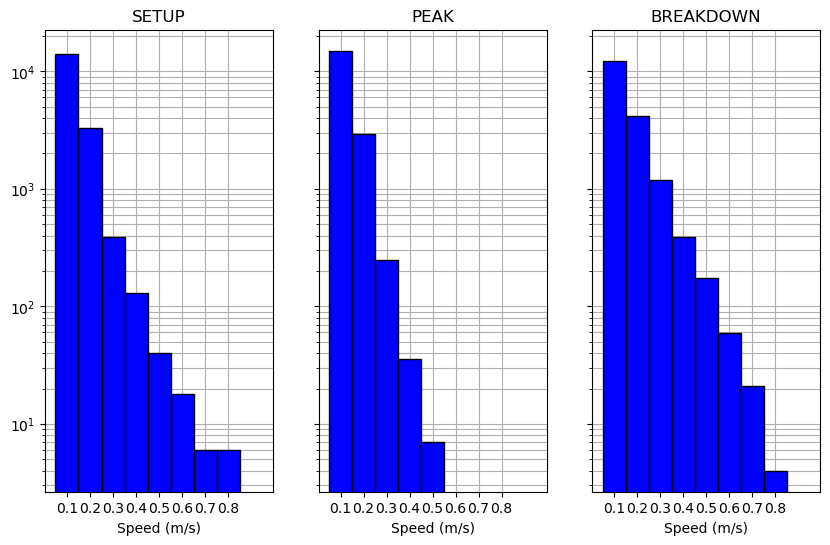

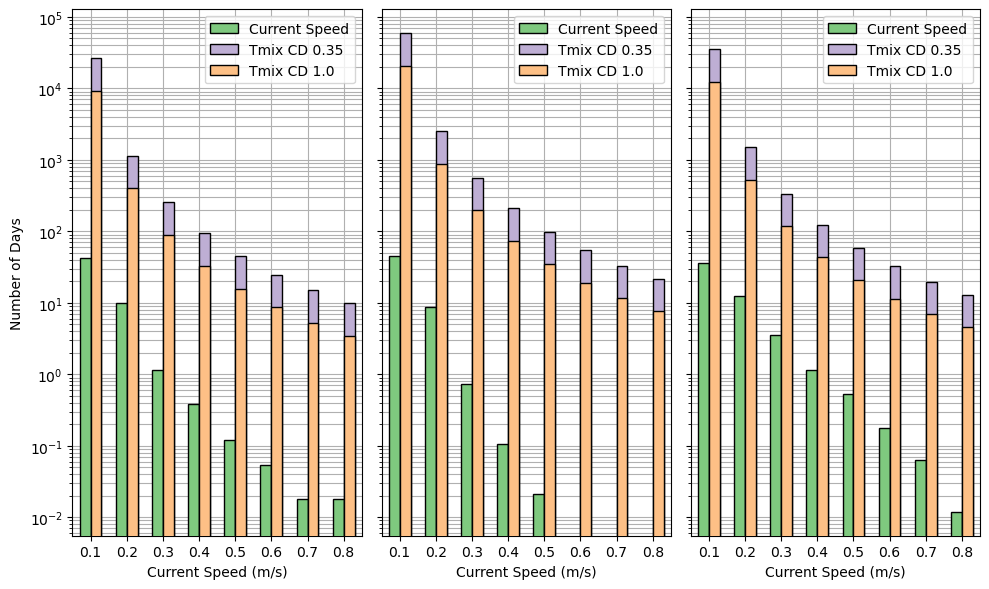

In [7]:
H = '25' #'25'
#read in results from the steady-state model
tmix = pd.read_csv('./steady_state_results_H25.csv')

#define set up, peak, breakdown periods
wlas = ['OCS-A 0499']
pmonth = {'setup':[5,6],'peak':[7,8],'breakdown':[9,10]}


for wla in wlas:
    print(wla)
    dac_df['time']=pd.to_datetime(dac_df.time)
    fig,ax = plt.subplots(1,3,figsize=(10,6),sharex='row',sharey='row')
    fig1,ax1 = plt.subplots(1,3,figsize=(10,6),sharex='row',sharey='row')
    cc=0
    
    
    
    # subset to each period
    for per,months in pmonth.items():
        print(per)
        tmix_sub=tmix[tmix.per==per]
        dac_df_sub = dac_df[dac_df.time.dt.month.isin(months)]
    
        ubar_values = dac_df_sub['ubar']
        vbar_values = dac_df_sub['vbar']
        #plot a histogram of the DAC distribution
        spd = np.sqrt(ubar_values.values**2 + vbar_values.values**2)
        bins=np.arange(0.05,1.05,0.1)
        ax[cc].hist(spd, color='blue', bins=bins,edgecolor='black',log=True,label='Speed (m/s)',zorder=50)
        counts,_ = np.histogram(spd,bins=bins)
        year_scale = len(dac_df_sub.time.dt.year.unique())
        print(counts / (24 *year_scale))
        ax[cc].set_xlabel('Speed (m/s)')
        ax[cc].set_xticks(np.arange(0.1,0.9,0.1))
        ax[cc].set_xticklabels(np.round(np.arange(0.1,0.9,0.1),1))
        ax[cc].set_title(per.upper())
        ax[cc].grid(True,which='both',zorder=0)
    
    
        # plot the mixing time scale (number of days) as a layer histogram
        bbins = np.arange(0,1,0.1)
        tmix_sub['Current Velocity_bin'] = pd.cut(tmix_sub['Current Velocity'], bins=bbins) #, labels=np.arange(0.1, 0.7, 0.1), right=False)        
        # Now you can group by the binned velocity and calculate statistics
        grouped_035 = tmix_sub.groupby('Current Velocity_bin')['Tmix CD = 0.35'].median()
        grouped_1 = tmix_sub.groupby('Current Velocity_bin')['Tmix CD 1.0'].median()
    
        width=0.3
        
        bar_lab = np.arange(len(counts))
        
    
        ax1[cc].bar(bar_lab-width/2, counts/(24*14), width=width,color='#7fc97f', edgecolor='black', label='Current Speed',zorder=5)
        ax1[cc].bar(bar_lab+width/2 , grouped_035, width=width,color='#beaed4', edgecolor='black', label='Tmix CD 0.35',zorder=5)
        ax1[cc].bar(bar_lab+width/2, grouped_1, width=width, color='#fdc086', edgecolor='black', label='Tmix CD 1.0',zorder=5)
        ax1[cc].set_yscale('log')
        ax1[cc].set_xticks(bar_lab)
        ax1[cc].set_xticklabels(np.round(np.arange(0.1,1,0.1),1))
        ax1[cc].set_xlim(bar_lab[0]-width-0.2,bar_lab[-2]+width+0.2)
        ax1[0].set_ylabel('Number of Days')
        ax1[cc].set_xlabel('Current Speed (m/s)')
        ax1[cc].legend()
        ax1[cc].grid(True,which='both',zorder=0)
        fig1.tight_layout()
        cc+=1

## Use the DAC and unsteady model results to generate a histogram comparing the number of days currents are experienced and the calculated mixing time scales for each period

OCS-A 0499
setup
[4.19226190e+01 9.76785714e+00 1.16071429e+00 3.86904762e-01
 1.19047619e-01 5.35714286e-02 1.78571429e-02 1.78571429e-02
 0.00000000e+00]


C:\Users\JuliaEngdahl\AppData\Local\Temp\ipykernel_24120\37195202.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmix_sub['Current Velocity_bin'] = pd.cut(tmix_sub['Current Velocity'], bins=bbins) #, labels=np.arange(0.1, 0.7, 0.1), right=False)
C:\Users\JuliaEngdahl\AppData\Local\Temp\ipykernel_24120\37195202.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_035 = tmix_sub.groupby('Current Velocity_bin')['Tmix CD = 0.35'].median()
C:\Users\JuliaEngdahl\AppData\Local\Temp\ipykernel_24120\37195202.py:46: FutureWarning: The default of observed

peak
[4.45416667e+01 8.69642857e+00 7.41071429e-01 1.07142857e-01
 2.08333333e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
breakdown
[3.65565476e+01 1.25148810e+01 3.53869048e+00 1.15178571e+00
 5.23809524e-01 1.75595238e-01 6.25000000e-02 1.19047619e-02
 0.00000000e+00]


C:\Users\JuliaEngdahl\AppData\Local\Temp\ipykernel_24120\37195202.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmix_sub['Current Velocity_bin'] = pd.cut(tmix_sub['Current Velocity'], bins=bbins) #, labels=np.arange(0.1, 0.7, 0.1), right=False)
C:\Users\JuliaEngdahl\AppData\Local\Temp\ipykernel_24120\37195202.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_035 = tmix_sub.groupby('Current Velocity_bin')['Tmix CD = 0.35'].median()
C:\Users\JuliaEngdahl\AppData\Local\Temp\ipykernel_24120\37195202.py:46: FutureWarning: The default of observed

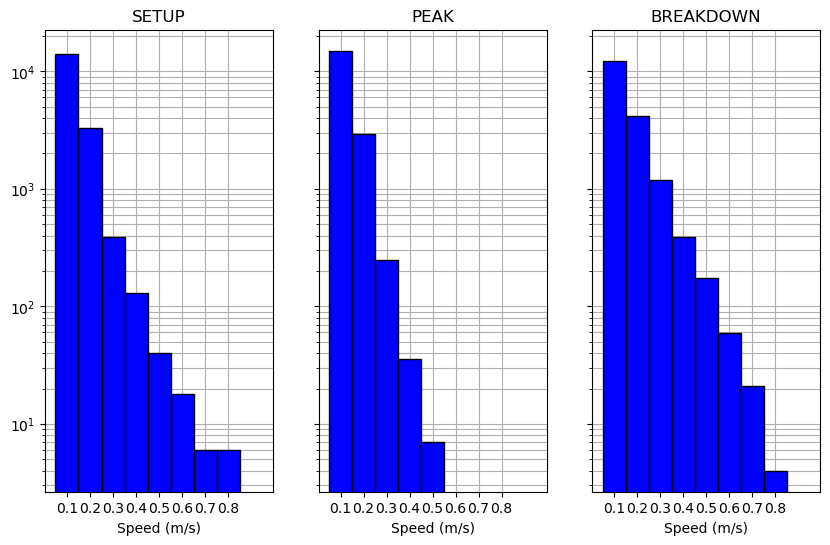

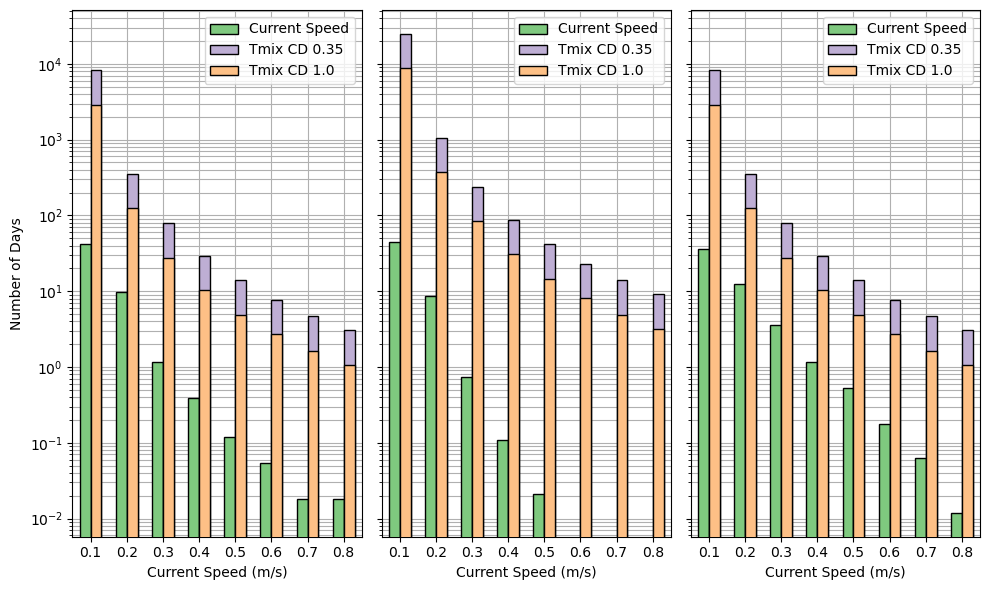

In [8]:
H = '25' #'25'
#read in results from the steady-state model
tmix = pd.read_csv('./unsteady_results_H25.csv')

#define set up, peak, breakdown periods
wlas = ['OCS-A 0499']
pmonth = {'setup':[5,6],'peak':[7,8],'breakdown':[9,10]}


for wla in wlas:
    print(wla)
    dac_df['time']=pd.to_datetime(dac_df.time)
    fig,ax = plt.subplots(1,3,figsize=(10,6),sharex='row',sharey='row')
    fig1,ax1 = plt.subplots(1,3,figsize=(10,6),sharex='row',sharey='row')
    cc=0
    
    
    
    # subset to each period
    for per,months in pmonth.items():
        print(per)
        tmix_sub=tmix[tmix.per==per]
        dac_df_sub = dac_df[dac_df.time.dt.month.isin(months)]
    
        ubar_values = dac_df_sub['ubar']
        vbar_values = dac_df_sub['vbar']
        #plot a histogram of the DAC distribution
        spd = np.sqrt(ubar_values.values**2 + vbar_values.values**2)
        bins=np.arange(0.05,1.05,0.1)
        ax[cc].hist(spd, color='blue', bins=bins,edgecolor='black',log=True,label='Speed (m/s)',zorder=50)
        counts,_ = np.histogram(spd,bins=bins)
        year_scale = len(dac_df_sub.time.dt.year.unique())
        print(counts / (24 *year_scale))
        ax[cc].set_xlabel('Speed (m/s)')
        ax[cc].set_xticks(np.arange(0.1,0.9,0.1))
        ax[cc].set_xticklabels(np.round(np.arange(0.1,0.9,0.1),1))
        ax[cc].set_title(per.upper())
        ax[cc].grid(True,which='both',zorder=0)
    
    
        # plot the mixing time scale (number of days) as a layer histogram
        bbins = np.arange(0,1,0.1)
        tmix_sub['Current Velocity_bin'] = pd.cut(tmix_sub['Current Velocity'], bins=bbins) #, labels=np.arange(0.1, 0.7, 0.1), right=False)        
        # Now you can group by the binned velocity and calculate statistics
        grouped_035 = tmix_sub.groupby('Current Velocity_bin')['Tmix CD = 0.35'].median()
        grouped_1 = tmix_sub.groupby('Current Velocity_bin')['Tmix CD 1.0'].median()
    
        width=0.3
        
        bar_lab = np.arange(len(counts))
        
    
        ax1[cc].bar(bar_lab-width/2, counts/(24*14), width=width,color='#7fc97f', edgecolor='black', label='Current Speed',zorder=5)
        ax1[cc].bar(bar_lab+width/2 , grouped_035, width=width,color='#beaed4', edgecolor='black', label='Tmix CD 0.35',zorder=5)
        ax1[cc].bar(bar_lab+width/2, grouped_1, width=width, color='#fdc086', edgecolor='black', label='Tmix CD 1.0',zorder=5)
        ax1[cc].set_yscale('log')
        ax1[cc].set_xticks(bar_lab)
        ax1[cc].set_xticklabels(np.round(np.arange(0.1,1,0.1),1))
        ax1[cc].set_xlim(bar_lab[0]-width-0.2,bar_lab[-2]+width+0.2)
        ax1[0].set_ylabel('Number of Days')
        ax1[cc].set_xlabel('Current Speed (m/s)')
        ax1[cc].legend()
        ax1[cc].grid(True,which='both',zorder=0)
        fig1.tight_layout()
        cc+=1